#Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

#Load and explore data

In [ ]:
data = pd.read_csv('/content/training_shooter_game_cheater_dataset_500.csv')
print("Data shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

Data shape: (500, 11)

First 5 rows:
   Accuracy  HeadshotRatio  ReactionTime   KDRatio  MovementScore  \
0  0.368042       0.410939      0.417721  3.075720       0.725287   
1  0.473860       0.488284      0.483413  1.518791       0.820399   
2  0.515468       0.570603      0.122858  2.822926       0.695601   
3  0.459306       0.344376      0.177012  0.948325       0.754106   
4  0.146644       0.019248      0.219628  0.000000       0.431073   

   ShotsPerMinute  AvgKillDistance  AimCorrectionSpeed   WinRate  HoursPlayed  \
0       93.652952        38.212898            0.290634  0.329998   260.451989   
1       53.155097        40.883853            0.221064  0.444241   160.370667   
2      110.064756        51.599311            0.119878  0.513494   400.521361   
3       60.489593        46.134402            0.245620  0.586003   164.271151   
4       40.746629        38.501406            0.159795  0.430605     1.025661   

   Cheater  
0        1  
1        0  
2        1  
3        

#Initial visualization

<Figure size 1000x600 with 0 Axes>

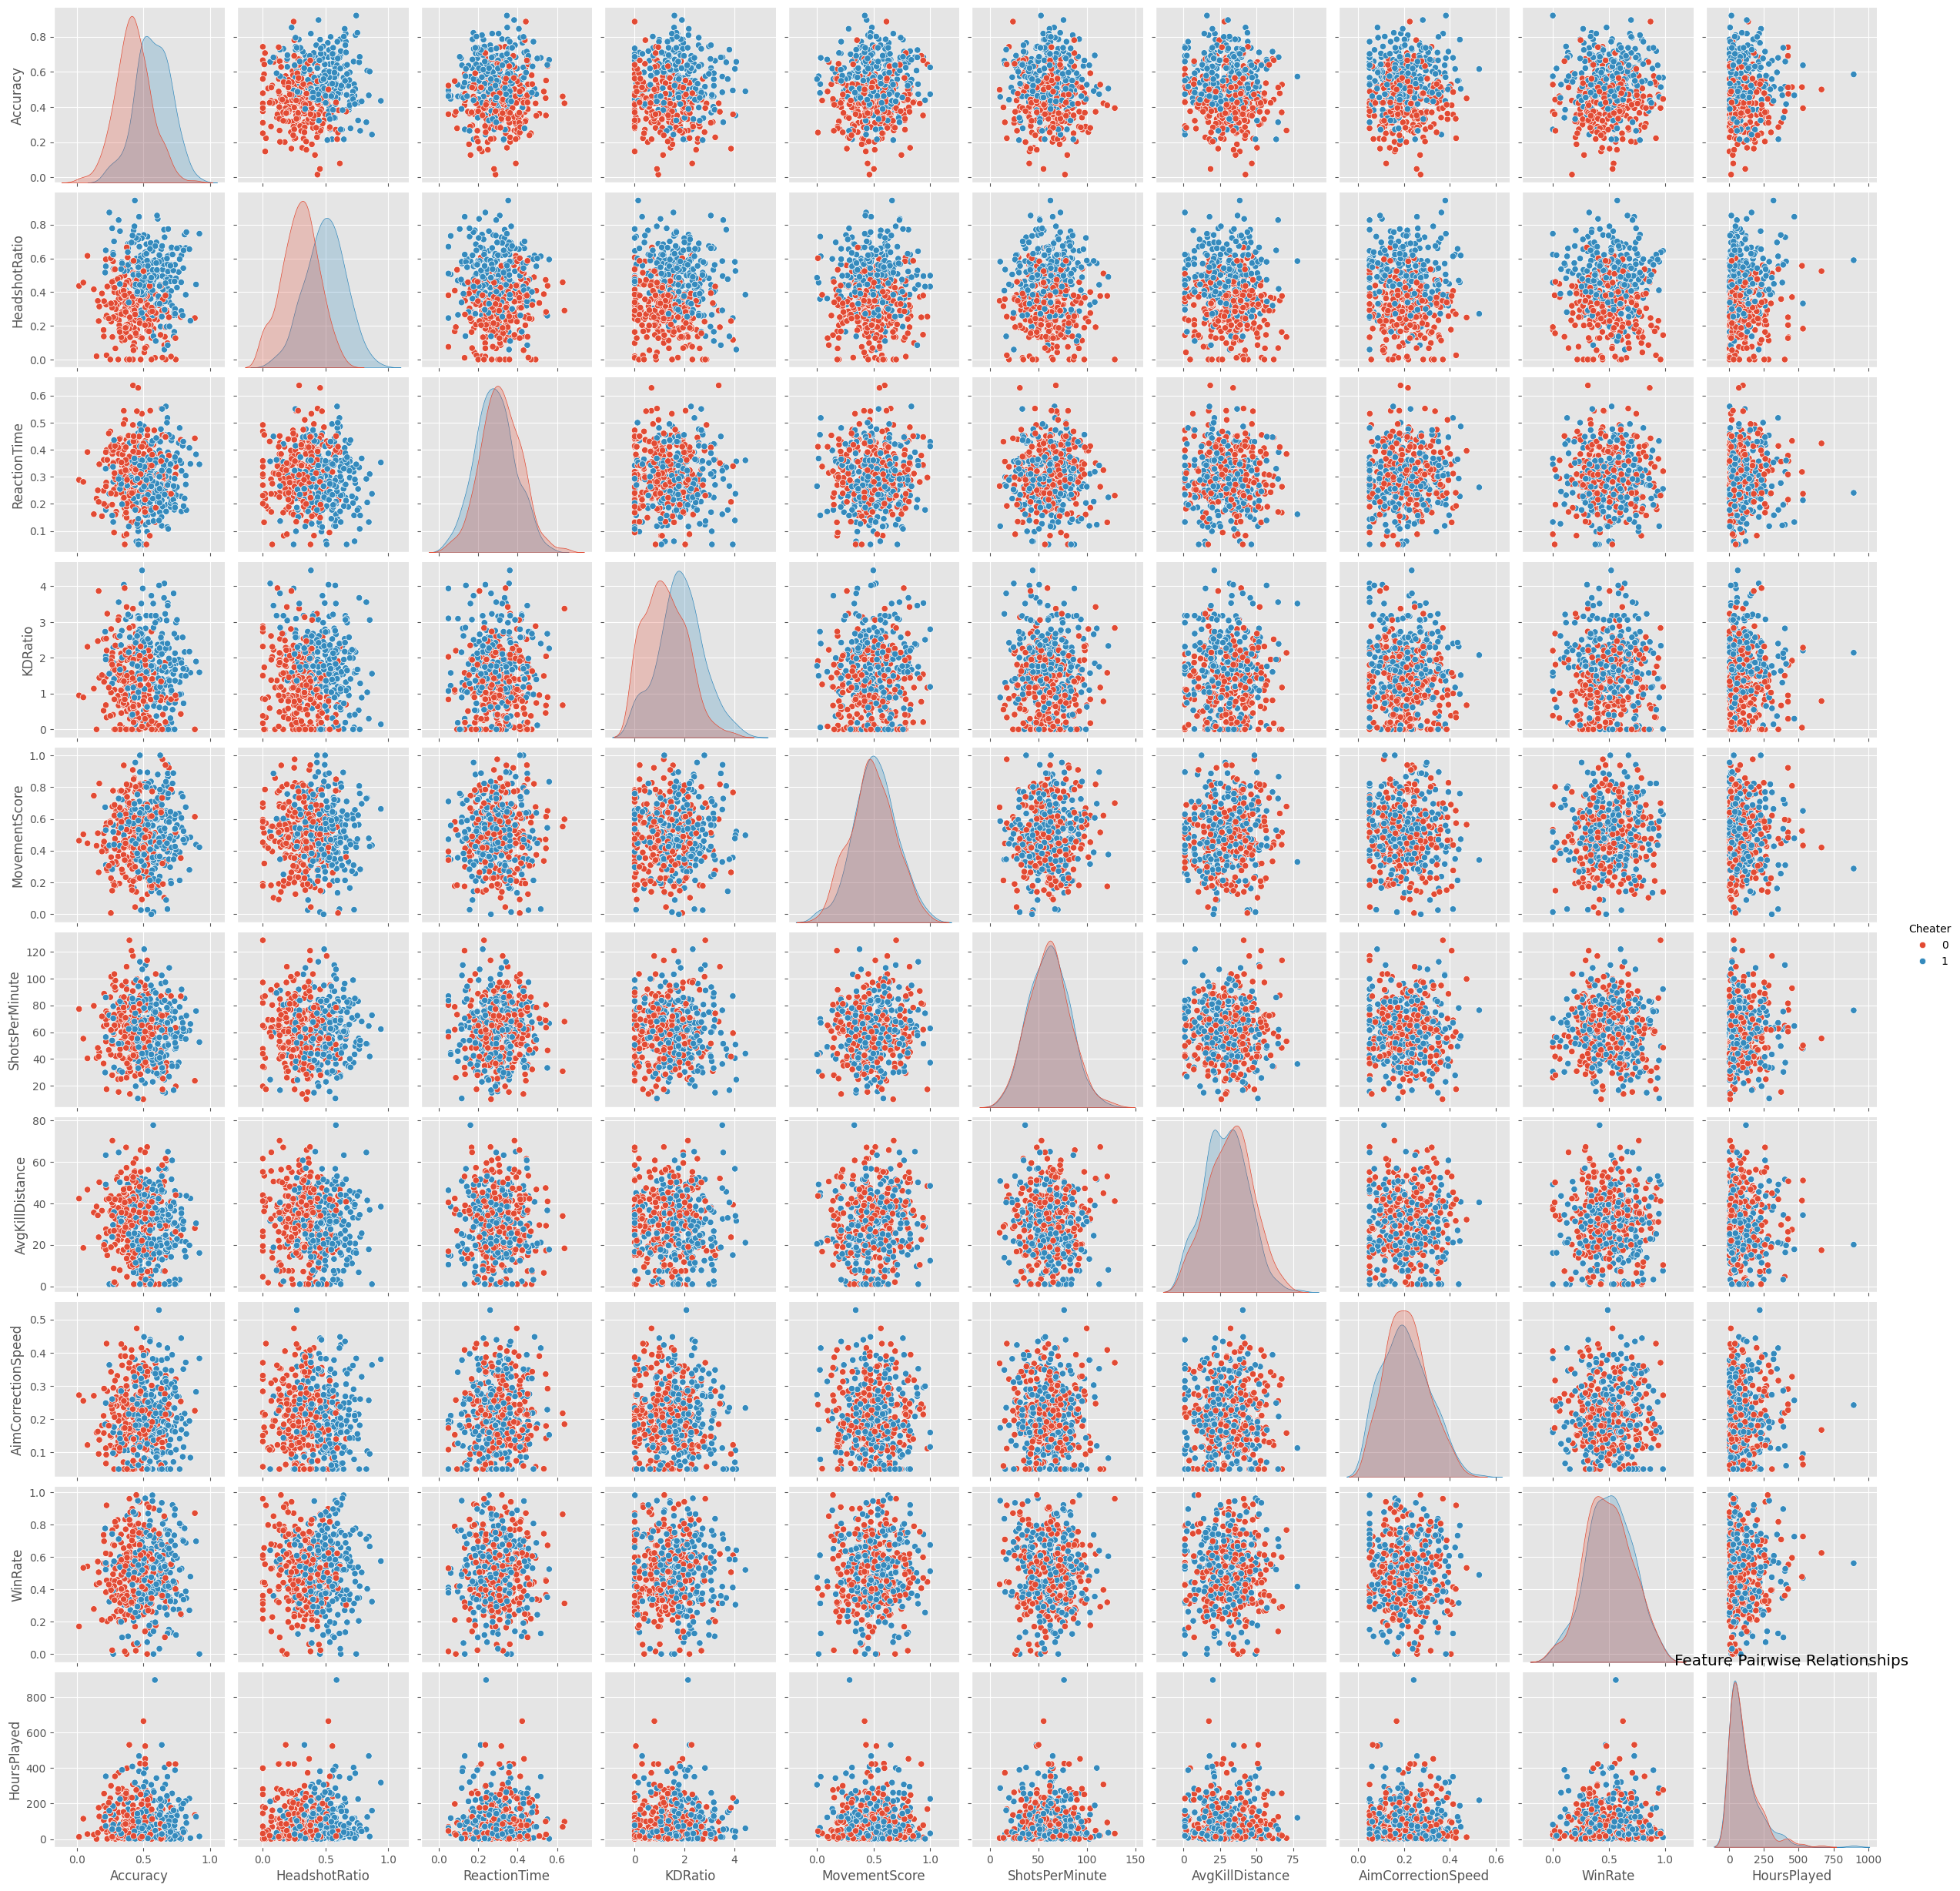

In [ ]:
plt.figure(figsize=(10, 6))
sns.pairplot(data, hue='Cheater')
plt.title('Feature Pairwise Relationships')
plt.show()

#Data preprocessing - handle missing values

In [ ]:
print("\nMissing values:")
print(data.isnull().sum())
# data = data.dropna() or fillna() as needed


Missing values:
Accuracy              0
HeadshotRatio         0
ReactionTime          0
KDRatio               0
MovementScore         0
ShotsPerMinute        0
AvgKillDistance       0
AimCorrectionSpeed    0
WinRate               0
HoursPlayed           0
Cheater               0
dtype: int64


#Prepare features and target

In [ ]:

X = data.drop('Cheater', axis=1).values
y = data['Cheater'].values
y = np.where(y <= 0, -1, 1)  # Convert to -1/1 for SVM

def standardize(X):
    X_std = np.copy(X)
    for col in range(X.shape[1]):
        X_std[:, col] = (X[:, col] - X[:, col].mean()) / X[:, col].std()
    return X_std

X = standardize(X)

#SVM *Implementation*

In [ ]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        # Convert y to NumPy array to avoid KeyError
        y = y.to_numpy()

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

#Train/Test Split

In [ ]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)

    n_samples = X.shape[0]
    test_samples = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)

    X_train, X_test = X[indices[test_samples:]], X[indices[:test_samples]]
    y_train, y_test = y[indices[test_samples:]], y[indices[:test_samples]]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train the model

In [ ]:
svm = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000)
svm.fit(X_train, y_train)

#Evaluate model


In [ ]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

y_pred = svm.predict(X_test)
acc = accuracy(y_test, y_pred)
print(f"\nModel Accuracy: {acc:.2%}")


Model Accuracy: 50.00%


#Visualization functions

In [ ]:
def visualize_svm():
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1)

    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, svm.w, svm.b, 0)
    x1_2 = get_hyperplane_value(x0_2, svm.w, svm.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, svm.w, svm.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, svm.w, svm.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, svm.w, svm.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, svm.w, svm.b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], 'y--')
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], 'k')
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], 'k')

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.title('SVM Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

def plot_learning_curve(X_train, y_train, X_test, y_test, max_iters=1000, step=50):
    train_errors = []
    test_errors = []
    iterations = range(50, max_iters, step)

    for n in iterations:
        svm = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=n)
        svm.fit(X_train, y_train)

        train_pred = svm.predict(X_train)
        test_pred = svm.predict(X_test)

        train_errors.append(1 - accuracy(y_train, train_pred))
        test_errors.append(1 - accuracy(y_test, test_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, train_errors, label='Training Error')
    plt.plot(iterations, test_errors, label='Test Error')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error Rate')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

#Visualize results


Visualization only works for 2D data. Consider PCA for dimensionality reduction.


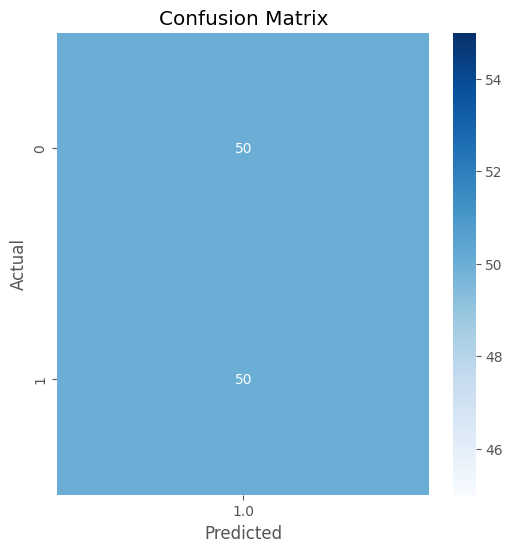

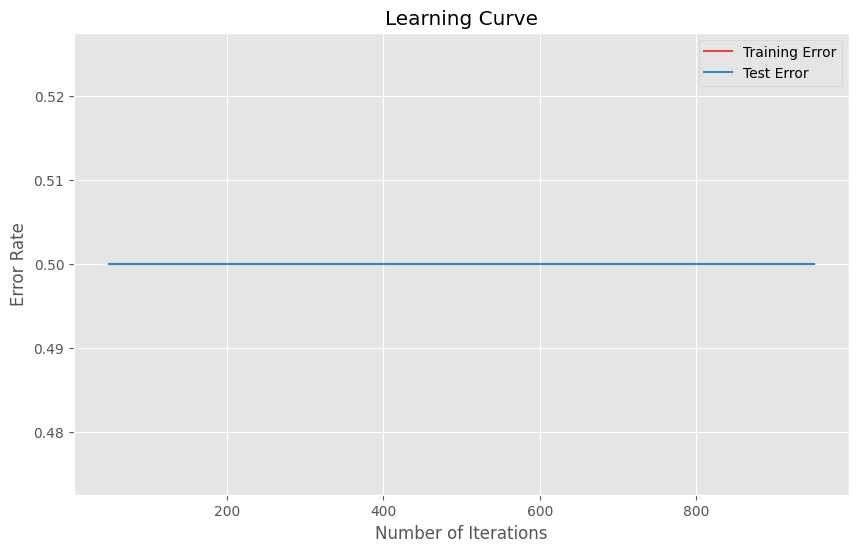

In [ ]:
if X.shape[1] == 2:
    visualize_svm()
else:
    print("\nVisualization only works for 2D data. Consider PCA for dimensionality reduction.")

plot_confusion_matrix(y_test, y_pred)
plot_learning_curve(X_train, y_train, X_test, y_test)

#With Scikit Learning

#Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            classification_report, roc_curve, auc)
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

#Load and explore data

In [ ]:
data = pd.read_csv('/content/training_shooter_game_cheater_dataset_500.csv')
print("Data shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

# Check class distribution
print("\nClass distribution:")
print(data['Cheater'].value_counts())

#Initial visualization

In [ ]:
# Pairplot for feature relationships
plt.figure(figsize=(10, 6))
sns.pairplot(data, hue='Cheater')
plt.title('Feature Pairwise Relationships')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

#Data preprocessing

In [ ]:
# Handle missing values if any
print("Missing values:")
print(data.isnull().sum())

# Prepare features and target
X = data.drop('Cheater', axis=1)
y = data['Cheater']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#SVM Model Training

In [ ]:
# Create SVM classifier
svm = SVC(kernel='linear', C=1.0, random_state=42, probability=True)

# Train the model
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

#Model Evaluation

Accuracy: 26.00%


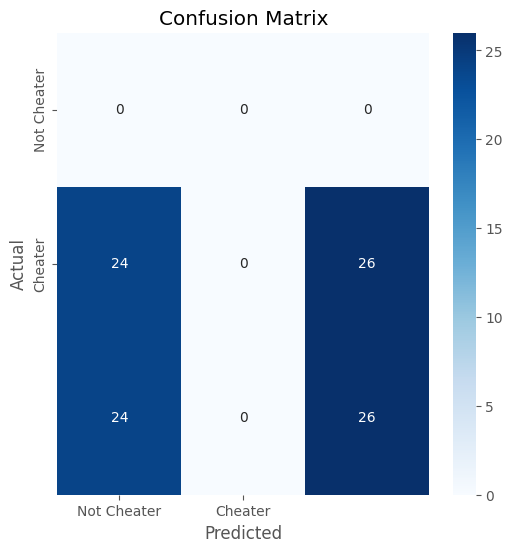


Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00        50
           1       0.50      0.52      0.51        50

    accuracy                           0.26       100
   macro avg       0.17      0.17      0.17       100
weighted avg       0.25      0.26      0.25       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

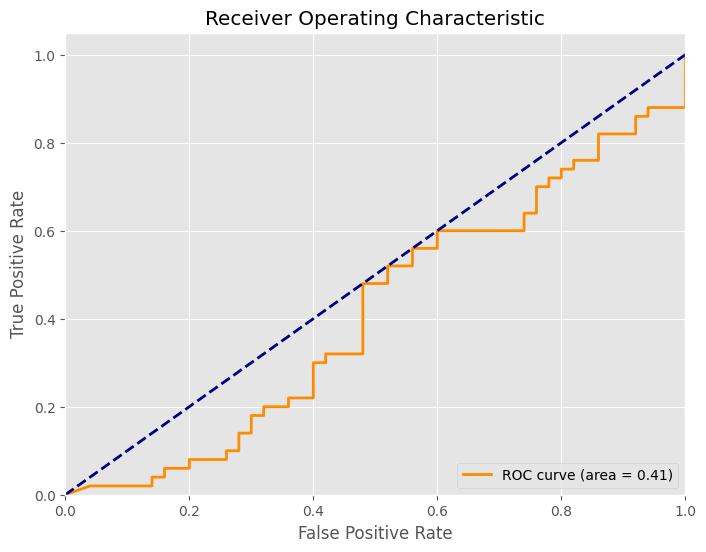

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Cheater', 'Cheater'],
            yticklabels=['Not Cheater', 'Cheater'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#Decision Boundary Visualization (for 2D)


Reducing dimensions with PCA for visualization...


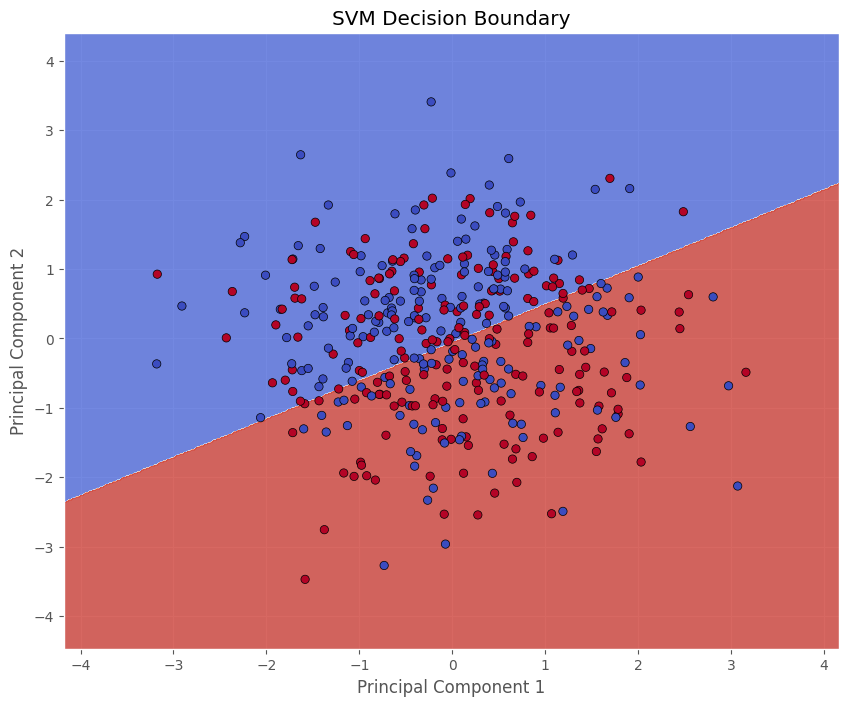

In [ ]:
# If more than 2 features, use PCA to reduce to 2 dimensions
if X.shape[1] > 2:
    print("\nReducing dimensions with PCA for visualization...")
    pca = PCA(n_components=2)
    X_vis = pca.fit_transform(X_train)
else:
    X_vis = X_train

# Create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Train a new SVM on the reduced dimensions for visualization
svm_vis = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1.0))
svm_vis.fit(X_vis, y_train)

# Plot decision boundary
Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Principal Component 1' if X.shape[1] > 2 else 'Feature 1')
plt.ylabel('Principal Component 2' if X.shape[1] > 2 else 'Feature 2')
plt.title('SVM Decision Boundary')
plt.show()

#Feature Importance (for linear kernel)


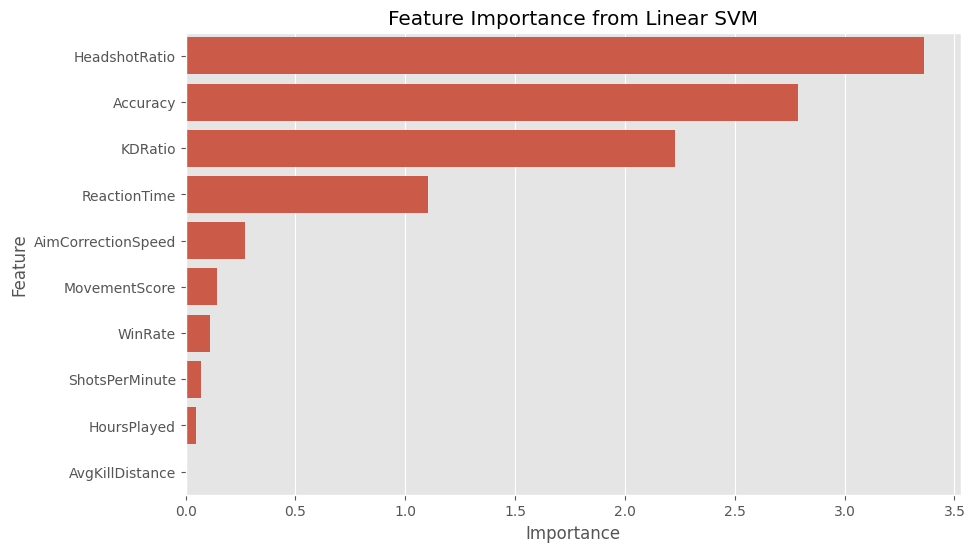

In [ ]:
if svm.kernel == 'linear':
    feature_importance = pd.DataFrame({
        'Feature': data.drop('Cheater', axis=1).columns,
        'Importance': np.abs(svm.coef_[0])
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance from Linear SVM')
    plt.show()

#Hyperparameter Tuning (Optional)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create grid search object
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_ * 100))

# Evaluate on test set
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test)
print("\nTest accuracy with best model: {:.2f}%".format(
    accuracy_score(y_test, y_pred_best) * 100))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 98.75%

Test accuracy with best model: 99.00%
